In [78]:
import os
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
torch.set_grad_enabled(True)
import os
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms

In [79]:
script_dir = os.getcwd()
emotion_processor = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression")
multi_face_model = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")

scene_weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
scene_checkpoint = torch.hub.load_state_dict_from_url(scene_weights_url, map_location="cpu")

original_scene_model = models.resnet18(num_classes=365)
original_scene_model.fc = nn.Linear(original_scene_model.fc.in_features, 365)
scene_state_dict = {k.replace("module.", ""): v for k, v in scene_checkpoint["state_dict"].items()}
original_scene_model.load_state_dict(scene_state_dict)
original_scene_model.eval()

# Preprocessing, the standard torchvision normalization for ResNet, VGG, DenseNet...
scene_tf = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]


In [80]:
from deepproblog.network import Network 
import torch.nn.functional as F

original_hf_emotion_model = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")

class MultiFaceWrapperFlat(nn.Module):
    def __init__(self, hf_model, max_faces=5):
        super().__init__()
        self.hf_model = hf_model
        self.max_faces = max_faces

    def forward(self, x):
        with torch.no_grad():
            if isinstance(x, list) and len(x) == 1 and isinstance(x[0], list):
                face_tensors = x[0]
            elif isinstance(x, list):
                face_tensors = x
            else:
                face_tensors = [x]
            
            face_probs_list = []
            
            for i, face_tensor in enumerate(face_tensors[:self.max_faces]):
                if torch.is_tensor(face_tensor):
                    face_batch = face_tensor.unsqueeze(0)
                    outputs = self.hf_model(face_batch)
                    probs = F.softmax(outputs.logits, dim=-1)
                    face_probs_list.append(probs.squeeze(0)) 
            
            while len(face_probs_list) < self.max_faces:
                face_probs_list.append(torch.zeros(7))
            
            result = torch.cat(face_probs_list, dim=0)
            return result

original_hf_emotion_model.eval()
for p in original_hf_emotion_model.parameters():
    p.requires_grad = False

max_faces = 5
multi_face_model = MultiFaceWrapperFlat(original_hf_emotion_model, max_faces=max_faces)

# We freeze the network for now because it is already pretrained
# Freeze multi-face (no optimizer)
multi_face_model.eval()
for p in multi_face_model.parameters():
    p.requires_grad = False
multi_face_network = Network(multi_face_model, "multi_face_net", batching=False)
multi_face_network.optimizer = None  # no training
    
class SceneFeatureExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.backbone = nn.Sequential(*list(model.children())[:-1])

    def forward(self, x):
        with torch.no_grad():
            if isinstance(x, list):
                x = torch.stack(x, dim=0)
            elif len(x.shape) == 3:
                x = x.unsqueeze(0)
                
            feats = self.backbone(x)
            feats = feats.view(feats.size(0), -1)

            return feats

scene_model = SceneFeatureExtractor(original_scene_model)
# Freeze scene feature extractor
scene_model.eval()
for p in scene_model.parameters():
    p.requires_grad = False
scene_network = Network(scene_model, "scene_net", batching=True)
scene_network.optimizer = None  # no training

class Scene2EmotionNet(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=128, output_dim=7, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        if not self.training:
            with torch.no_grad():
                x = F.relu(self.fc1(x))
                x = self.dropout(x)
                return self.fc2(x)
        else:
            x = F.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.fc2(x)
            return torch.clamp(x, min=-10, max=10)
    
scene2emo_model = Scene2EmotionNet()
# Trainable adapter
scene2emo_model.train()
scene2emo_network = Network(scene2emo_model, "scene2emo_net", batching=True)
scene2emo_network.optimizer = torch.optim.Adam(scene2emo_network.parameters(), lr=1e-4)

In [81]:
import os
import pandas as pd
import random
from io import StringIO
import matplotlib.pyplot as plt
from IPython.display import display
import random
import matplotlib.pyplot as plt
import cv2
from PIL import Image

script_dir = os.getcwd()
labels_dir = os.path.join(script_dir, "../data/findingemo/labels")
base_findingemo_dir = os.path.join(script_dir, "../data/findingemo")
csv_path = os.path.join(labels_dir, "annotations_cleaned.csv")
df_findingEmo = pd.read_csv(csv_path)

In [82]:
# Get the different emotions from FindingEmo
emotion_labels_findingemo = df_findingEmo['emotion'].unique().tolist()
emotion_to_idx = {emotion: idx for idx, emotion in enumerate(emotion_labels_findingemo)}
print(emotion_labels_findingemo)

['Trust', 'Interest', 'Apprehension', 'Anticipation', 'Anger', 'Joy', 'Grief', 'Serenity', 'Boredom', 'Ecstasy', 'Fear', 'Vigilance', 'Sadness', 'Rage', 'Annoyance', 'Acceptance', 'Terror', 'Amazement', 'Surprise', 'Pensiveness', 'Admiration', 'Loathing', 'Distraction', 'Disgust']


In [83]:
# train_test split
from sklearn.model_selection import train_test_split
# Shuffle the dataset
df_findingEmo = df_findingEmo.sample(frac=1, random_state=42).reset_index(drop=True)
train_df, test_df = train_test_split(df_findingEmo, test_size=0.2, random_state=42)

# reset indexes
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df = train_df.iloc[:200]

In [84]:
from mtcnn import MTCNN
# Image access (tensors) - separate classes for different preprocessing
class FindingEmoFaceImages(object):
    def __init__(self, subset, prints=False):
        self.subset = subset
        self.face_detector = MTCNN()
        self.face_tensors = {}
        self.prints = prints

        if self.subset == "train":
            self.dataframe = train_df.copy()
        else:
            self.dataframe = test_df.copy()
# Will return a list of tensors corresponding to all the detected faces.
# If no face is detected, just return the tensor of the image.
    def __getitem__(self, item):
        index = int(item[0]) if isinstance(item, (tuple, list)) else int(item)
        
        image_path = self.dataframe["image_path"][index]
        if image_path.startswith('/'):
            image_path = image_path[1:]
        
        img_path = os.path.join(base_findingemo_dir, image_path)
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Detect the faces
        face_results = self.face_detector.detect_faces(img)

        # Sort faces from bigger to smaller
        face_results = sorted(face_results, key=lambda x: x['box'][2] * x['box'][3], reverse=True)

        # Only max faces
        face_results = face_results[:max_faces]

        face_tensors = []
        face_pils = []

        if len(face_results) > 0:
            for face_result in face_results:
                x, y, w, h = face_result['box']

                # Handle negative coordinates and bounds
                x = max(0, x)
                y = max(0, y)
                x2 = min(img.shape[1], x + w)
                y2 = min(img.shape[0], y + h)

                # Face crop
                face_crop = img[y:y2, x:x2] 
                # Skip if the crop is too small
                if face_crop.shape[0] < 10 or face_crop.shape[1] < 10:
                    continue

                # Converting to PIL and process it with HF processor
                face_pil = Image.fromarray(face_crop)
                face_pils.append(face_pil)
                face_input = emotion_processor(images=face_pil, return_tensors="pt")
                face_tensors.append(face_input['pixel_values'].squeeze(0))

        if len(face_tensors) == 0:
            # Use whole image as fallback
            img_pil = Image.fromarray(img)
            face_pils.append(img_pil)
            face_input = emotion_processor(images = img_pil, return_tensors="pt")
            face_tensors.append(face_input['pixel_values'].squeeze(0))
        
        if self.prints:
            self.face_tensors[index] = face_pils
            
        return face_tensors
    
    def print_faces_and_image(self, i):
        _ = self.__getitem__(i)

        if i in self.face_tensors:
            face_tensors = self.face_tensors[i]
            num_faces = len(face_tensors)
            if num_faces > 0:
                plt.figure(figsize=(8, 3))
            for j, face_tensor in enumerate(face_tensors):
                plt.subplot(1, num_faces, j + 1)
                plt.imshow(face_tensor)
                plt.title(f'Face {j}')
                plt.axis('off')
            plt.show()

        # Print the original image
        image_path = self.dataframe["image_path"][i]
        if image_path.startswith('/'):
            image_path = image_path[1:]
        img_path = os.path.join(base_findingemo_dir, image_path)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title('Image: ' + str(i) + ' : ' + self.dataframe["emotion"][i])
        plt.axis('off')
        plt.show()

class FindingEmoSceneImages(object):
    def __init__(self, subset):
        self.subset = subset
        if self.subset == "train":
            self.dataframe = train_df.copy()
        else:
            self.dataframe = test_df.copy()
            
    def __getitem__(self, item):
        index = int(item[0]) if isinstance(item, (tuple, list)) else int(item)
        
        image_path = self.dataframe["image_path"][index]
        if image_path.startswith('/'):
            image_path = image_path[1:]
        
        img_path = os.path.join(base_findingemo_dir, image_path)
        
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")
            
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Failed to load image: {img_path}")
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img)
        
        # Use scene transforms for scene model
        scene_tensor = scene_tf(img_pil)
        return scene_tensor

# Create separate instances
FindingEmoFace_train_ex = FindingEmoFaceImages("train", prints=True)
FindingEmoFace_train = FindingEmoFaceImages("train")
FindingEmoFace_test = FindingEmoFaceImages("test")
FindingEmoScene_train = FindingEmoSceneImages("train") 
FindingEmoScene_test = FindingEmoSceneImages("test")

In [85]:
emotion_categories = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

In [86]:
# Mapping for the scene categories. Read them from ../data/places365/categories_places365.txt
scene_categories = []
with open(os.path.join(script_dir, "../data/places365/categories_places365.txt")) as f:
    for line in f:
        scene = line.strip().split(' ')[0][3:]
        scene_categories.append(scene)

model_scene_to_index = {scene: idx for idx, scene in enumerate(scene_categories)}

In [87]:
from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.engines import ExactEngine
from deepproblog.dataset import Dataset, DataLoader
from torch.utils.data import Dataset as TorchDataset
from problog.logic import Term, Constant, Var
from deepproblog.query import Query
from deepproblog.train import train_model

In [88]:
num_emotions = len(emotion_categories) * max_faces
num_scenes = len(scene_categories)

emotion_indices = list(range(num_emotions))
scene_indices = list(range(num_scenes))

In [89]:
train_indices = list(range(len(train_df))) 
test_indices = list(range(len(test_df))) 

In [90]:
from deepproblog.engines import ApproximateEngine, ExactEngine
# Create model
model = Model(
    os.path.join(script_dir, "model.pl"),
    [multi_face_network, scene_network, scene2emo_network]
)
model.set_engine(ExactEngine(model), cache=True)
# from deepproblog.engines.prolog_engine.heuristics import PartialProbability
# model.set_engine(ApproximateEngine(model, k=1, heuristic=PartialProbability(), exploration=False))

# Register tensor sources
model.add_tensor_source("train_face", FindingEmoFace_train)
model.add_tensor_source("test_face", FindingEmoFace_test)
model.add_tensor_source("train_scene", FindingEmoScene_train)
model.add_tensor_source("test_scene", FindingEmoScene_test)

Caching ACs


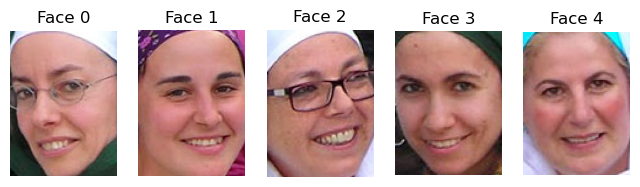

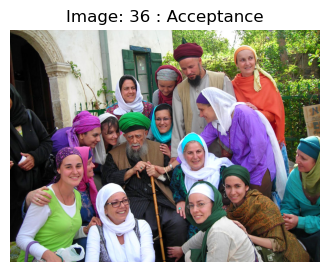

In [91]:
train_sample_idx = random.randint(0, len(train_df) - 1)
FindingEmoFace_train_ex.print_faces_and_image(train_sample_idx)

In [92]:
# # Query emotion distribution over the detected faces
# query_1 = Query(
#     Term("faces",
#          Term("tensor", Term("train_face", Constant(train_sample_idx))),
#          Var("AllEmotions")),
#     substitution={}
# )

# results_1 = model.solve([query_1])
# results_1_dict = results_1[0].result

# emotion_probs = []
# for i in range(max_faces * len(emotion_categories)): 
#     key_found = False
#     for key, prob in results_1_dict.items():
#         # Extract index from the key string like "faces(tensor(train_face(1234)),5)"
#         if str(key).endswith(f",{i})"):
#             emotion_probs.append(prob)
#             key_found = True
#             break
#     if not key_found:
#         emotion_probs.append(0.0) 

# for face_idx in range(max_faces):
#     start_idx = face_idx * 7
#     end_idx = start_idx + 7
#     face_emotion_probs = emotion_probs[start_idx:end_idx]
    
#     if sum(face_emotion_probs) > 0.01:  
#         print(f"FACE {face_idx}:")
#         print("")
        
#         emotion_prob_pairs = [(emotion_categories[i], prob) for i, prob in enumerate(face_emotion_probs)]
        
#         for emotion, prob in emotion_prob_pairs:
#             print(f"{emotion:8}: {prob:.4f}")


In [93]:
# # Probability of face 1 being happy:
# query_2 = Query(
#     Term("face_emotion_prob",
#          Term("tensor", Term("train_face", Constant(train_sample_idx))),
#          Constant(1),
#          Constant(emotion_categories.index('happy'))),
#     substitution={}
# )

# results_2 = model.solve([query_2])
# print(results_2)

In [94]:
# # Probability distribution over all emotions for face 1:
# query_3 = Query(
#     Term("face_emotion_prob",
#          Term("tensor", Term("train_face", Constant(train_sample_idx))),
#          Constant(1),
#          Var("EmotionIdx")),
#     substitution={}
# )

# results_3 = model.solve([query_3])
# print(results_3)

In [95]:
# # Scene distribution
# query_4 = Query(
#     Term("scene",
#          Term("tensor", Term("train_scene", Constant(train_sample_idx))),
#          Var("SceneIdx")),
#     substitution={}
# )

# results_4 = model.solve([query_4])

# results_4_dict = results_4[0].result

# top_scenes = {}
# for key, prob in results_4_dict.items():
#     # Extract index from the key string like "scene(tensor(train_scene(1234)),5)"
#     if str(key).endswith(")"):
#         scene_idx = int(str(key).split(",")[-1][:-1])
#         scene_name = scene_categories[scene_idx]
#         top_scenes[scene_name] = prob

# top_scenes_sorted = dict(sorted(top_scenes.items(), key=lambda item: item[1], reverse=True))
# print("\nTop scene predictions:")
# for scene, prob in list(top_scenes_sorted.items())[:10]:
#     print(f"   {scene:20}: {prob:.4f}")

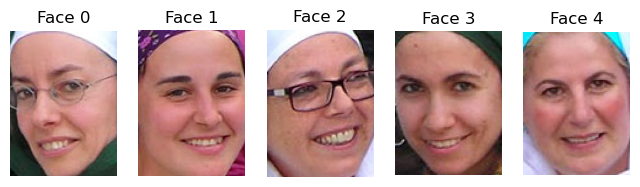

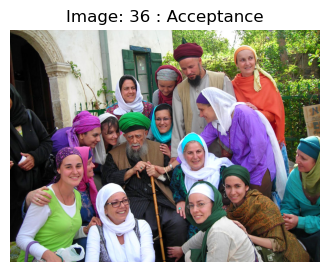

Final Emotion Predictions:
Joy            : 0.4598
Ecstasy        : 0.2299
Serenity       : 0.2214
Admiration     : 0.1149
Acceptance     : 0.1050
Fear           : 0.0507
Apprehension   : 0.0253
Terror         : 0.0253
Vigilance      : 0.0253
Anger          : 0.0120
Surprise       : 0.0057
Sadness        : 0.0034
Amazement      : 0.0034
Distraction    : 0.0023
Grief          : 0.0020
Rage           : 0.0015
Annoyance      : 0.0015
Pensiveness    : 0.0013
Boredom        : -0.0152
Loathing       : -0.0587
Disgust        : -0.1369


In [96]:
FindingEmoFace_train_ex.print_faces_and_image(train_sample_idx)

query = Query(
    Term("final_findingemo",
         Term("tensor", Term("train_face", Constant(train_sample_idx))),
         Term("tensor", Term("train_scene", Constant(train_sample_idx))),
         Var("FEIdx")),
    substitution={}
)

results_final = model.solve([query])
results_final_dict = results_final[0].result

# Sort by tensor values and display in a readable format
sorted_results = sorted(results_final_dict.items(), key=lambda x: x[1].item(), reverse=True)

print("Final Emotion Predictions:")
print("=" * 60)

for key, tensor_val in sorted_results:
    # Extract emotion index from the key
    key_str = str(key)
    emotion_idx = int(key_str.split(",")[-1][:-1])
    emotion_name = emotion_labels_findingemo[emotion_idx]
    probability = tensor_val.item()
    
    print(f"{emotion_name:15}: {probability:.4f}")

In [97]:
import json
from typing import Tuple

# Dataset for training
class FindingEmoDataset(Dataset, TorchDataset):
    def __init__(self, dataframe, subset_name, function_name="final_findingemo"):
        super(FindingEmoDataset, self).__init__()
        self.dataframe = dataframe.reset_index(drop=True)
        self.subset_name = subset_name
        self.function_name = function_name
        self.data = list(range(len(self.dataframe)))
    
    def __getitem__(self, index: int) -> Tuple[int, str, int]:
        sample_idx = self.data[index]
        emotion_name = self.dataframe.iloc[sample_idx]['emotion']
        emotion_idx = emotion_to_idx[emotion_name]
        return sample_idx, emotion_name, emotion_idx
    
    def __len__(self):
        return len(self.data)
    
    def to_query(self, i: int) -> Query:
        sample_idx = self.data[i]
        emotion_idx = emotion_to_idx[self.dataframe.iloc[sample_idx]['emotion']]
        
        query = Query(
            Term(self.function_name,
                 Term("tensor", Term(f"{self.subset_name}_face", Constant(sample_idx))),
                 Term("tensor", Term(f"{self.subset_name}_scene", Constant(sample_idx))),
                 Constant(emotion_idx)),  # Ground truth
            substitution={}
        )
        return query
    
    def get_label(self, i: int):
        sample_idx = self.data[i]
        emotion_name = self.dataframe.iloc[sample_idx]['emotion']
        return emotion_to_idx[emotion_name]
    
    def get_emotion_name(self, i: int):
        sample_idx = self.data[i]
        return self.dataframe.iloc[sample_idx]['emotion']

train_dataset = FindingEmoDataset(train_df, "train")
test_dataset = FindingEmoDataset(test_df, "test")

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Test the dataset
sample_idx, emotion_name, emotion_idx = train_dataset[0]
print(f"Sample 0: idx={sample_idx}, emotion='{emotion_name}', label={emotion_idx}")

# Test query generation
query = train_dataset.to_query(0)
print(f"Generated query: {query}")

Train dataset size: 200
Test dataset size: 4275
Sample 0: idx=0, emotion='Vigilance', label=11
Generated query: (1.0::final_findingemo(tensor(train_face(0)),tensor(train_scene(0)),11), {})


In [98]:
# Ensure output folders exist
snapshot_dir = os.path.join(script_dir, "snapshot")
log_dir = os.path.join(script_dir, "log")
os.makedirs(snapshot_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

In [99]:
import torch.optim as optim
from deepproblog.train import train_model
from deepproblog.utils.stop_condition import EpochStop

loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Sanity checks before training

In [100]:
import torch

x = torch.randn(1, 512)
out = scene2emo_model(x)
print("Scene2EmotionNet output:", out)
print("Any NaN?", torch.isnan(out).any())
print("Range:", out.min().item(), out.max().item())


Scene2EmotionNet output: tensor([[ 0.1871,  0.0044,  0.1701,  0.2390, -0.1547, -0.1479, -0.0017]],
       grad_fn=<ClampBackward1>)
Any NaN? tensor(False)
Range: -0.15473659336566925 0.2390223741531372


In [101]:
train = train_model(model, loader, EpochStop(1), log_iter=25, profile=0)

Training  for 1 epoch(s)
Epoch 1
Iteration:  25 	s:23.8971 	Average Loss:  nan


KeyboardInterrupt: 

In [ ]:
from json import dumps
from deepproblog.evaluate import get_confusion_matrix

# Save results
snapshot_path = os.path.join(snapshot_dir, "social_cognition" + ".pth")
model.save_state(snapshot_path)
print("Model snapshot saved to:", snapshot_path)

log_path = os.path.join(log_dir, "social_cognition")
train.logger.comment(dumps(model.get_hyperparameters()))
train.logger.comment("Accuracy {}".format(get_confusion_matrix(model, test_dataset, verbose=1).accuracy()))
train.logger.write_to_file(log_path)
print("Training log written to:", log_path) 

In [ ]:
# snapshot_path = os.path.join(script_dir, "snapshot", "social_cognition.pth")

# if os.path.exists(snapshot_path):
#     print(f"Loading model from: {snapshot_path}")
#     model.load_state(snapshot_path)
# else:
#     print("Error loading model")

Loading model from: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\snapshot\social_cognition.pth


Random index:  180


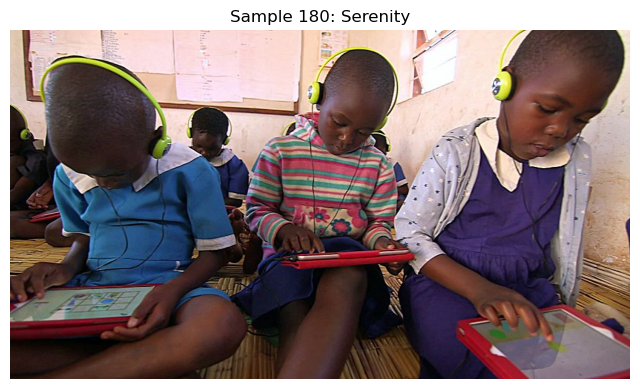

Number of detected faces: 2
Enhanced Final Emotion Predictions (sorted by probability):
Joy            : 0.5943
Acceptance     : 0.5866
Serenity       : 0.5836
Admiration     : 0.4841
Vigilance      : 0.0945
Boredom        : 0.0898
Sadness        : 0.0803
Terror         : 0.0691
Rage           : 0.0466
Ecstasy        : 0.0383
Annoyance      : 0.0310
Pensiveness    : 0.0306
Grief          : 0.0235
Fear           : 0.0208
Disgust        : 0.0179
Amazement      : 0.0144
Apprehension   : 0.0117
Distraction    : 0.0108
Loathing       : 0.0080
Surprise       : 0.0058
Anger          : 0.0036

Ground Truth: SERENITY
Enhanced Final Emotion Predictions (sorted by probability):
Joy            : 0.5943
Acceptance     : 0.5866
Serenity       : 0.5836
Admiration     : 0.4841
Vigilance      : 0.0945
Boredom        : 0.0898
Sadness        : 0.0803
Terror         : 0.0691
Rage           : 0.0466
Ecstasy        : 0.0383
Annoyance      : 0.0310
Pensiveness    : 0.0306
Grief          : 0.0235
Fear        

In [ ]:
test_sample_idx = random.randint(0, len(test_df) - 1)
FindingEmoFace_test.print_faces_and_image(test_sample_idx)
query = Query(
    Term("final_findingemo",
         Term("tensor", Term("test_face", Constant(test_sample_idx))),
         Term("tensor", Term("test_scene", Constant(test_sample_idx))),
         Var("FEIdx")),
    substitution={}
)

results_final = model.solve([query])
results_final_dict = results_final[0].result

# Sort by tensor values and display in a readable format
sorted_results = sorted(results_final_dict.items(), key=lambda x: x[1].item(), reverse=True)

print("Enhanced Final Emotion Predictions (sorted by raw logits):")
print("=" * 60)

for key, tensor_val in sorted_results:
    # Extract emotion index from the key
    key_str = str(key)
    emotion_idx = int(key_str.split(",")[-1][:-1])
    emotion_name = emotion_labels_findingemo[emotion_idx]
    probability = tensor_val.item()
    
    print(f"{emotion_name:15}: {probability:.4f}")

print(f"\nGround Truth: {test_df.iloc[test_sample_idx]['emotion'].upper()}")